In [20]:
from pyspecter.SPECTER import SPECTER
from pyshaper.Shaper import Shaper

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, random_triangles, kT_N
from pyspecter.utils.plot_utils import initialize, newplot, plot_event
initialize()


# Standard imports
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import time

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


In [21]:
def minkowski_dot(a, b):
    return a[:, 0] * b[:, 0] - np.sum(a[:, 1:] * b[:, 1:], axis=1)

def generate_RAMBO(num_events, num_particles, total_energy, seed=None):

    # Set seed if given
    if seed is not None:
        np.random.seed(seed)


    # Initial c, phi, e values from uniform distributions
    cos_theta = np.random.uniform(-1, 1, (num_events, num_particles))
    phi = np.random.uniform(0, 2 * np.pi, (num_events, num_particles))
    energy = -np.log(np.random.uniform(0, 1, (num_events, num_particles, 2)).prod(axis=2))
    mom_x = energy * np.sqrt(1 - cos_theta**2) * np.cos(phi)
    mom_y = energy * np.sqrt(1 - cos_theta**2) * np.sin(phi)
    mom_z = energy * cos_theta
    initial_momenta = np.stack([energy, mom_x, mom_y, mom_z], axis=-1)

    # Total momentum and invariant mass for each event
    total_momentum = initial_momenta.sum(axis=1)
    invariant_mass = np.sqrt(minkowski_dot(total_momentum, total_momentum))
    boost_vector = -total_momentum / invariant_mass[:, np.newaxis]
    scale_factor = total_energy / invariant_mass
    gamma_factor = total_momentum[:, 0] / invariant_mass
    a_factor = 1 / (1 + gamma_factor)

    # Rescaling and boosting for each event (vectorized)
    final_momenta = []
    for i in range(num_events):
        event_momenta = []
        for momentum in initial_momenta[i]:
            dot_boost_mom = np.dot(boost_vector[i:i+1, 1:], momentum[1:])
            energy = scale_factor[i] * (gamma_factor[i] * momentum[0] + dot_boost_mom)
            mom_x = scale_factor[i] * (momentum[1] + boost_vector[i, 1] * (momentum[0] + a_factor[i] * dot_boost_mom))
            mom_y = scale_factor[i] * (momentum[2] + boost_vector[i, 2] * (momentum[0] + a_factor[i] * dot_boost_mom))
            mom_z = scale_factor[i] * (momentum[3] + boost_vector[i, 3] * (momentum[0] + a_factor[i] * dot_boost_mom))
            event_momenta.append([energy, mom_x, mom_y, mom_z])
        final_momenta.append(event_momenta)

    # Convert to numpy array
    final_momenta = np.array(final_momenta)[:,:,:,0]

    # Calculate weights for phase space volume
    weights = ((total_energy ** 2) ** (num_particles - 2) * np.ones_like(scale_factor)) /  ((2 * np.pi) ** (3 * num_particles - 4)) * (np.pi / 2) ** (num_particles - 1) / (scipy.special.gamma(num_particles) * scipy.special.gamma(num_particles - 1))

    return final_momenta, weights / num_events

In [22]:
# 4 fermi decay matrix element
def matrix_element_squared(G_F, p_muon, p_electron, p_neutrino_mu, p_antineutrino_e):

    t = minkowski_dot(p_electron + p_neutrino_mu, p_electron + p_neutrino_mu)
    return 16 * G_F**2 * t * ( m_muon**2 - t)

# Function to estimate muon decay width
def estimate_muon_decay_width(m_muon, G_F, num_events, seed=None):
    num_particles = 3  # Three-body decay
    total_energy = m_muon  # Total energy is the muon mass
    decay_width_sum = 0

    p_muon = np.array([m_muon, 0, 0, 0])  # Muon at rest
    momenta, weights = generate_RAMBO(num_events, num_particles, total_energy, seed)

    me_square = matrix_element_squared(G_F, p_muon, momenta[:, 0], momenta[:, 1], momenta[:, 2])
    me_square_units = me_square  / (2 * m_muon)
    decay_width = np.sum(me_square_units * weights)

    # decay_width_variance = np.sum(me_square_units**2 * weights) - decay_width**2
    # standard_error = np.sqrt(decay_width_variance / num_events)
    
    # print("Standard Error:", standard_error)

    


    return decay_width

# Constants
m_muon = 105.66 / 1000  # Muon mass in GeV
G_F = 1.1663787e-5  # Fermi coupling constant in GeV^-2
num_events = 100000  # Number of Monte Carlo events
seed = 1234  # Seed for reproducibility

# Estimate the muon decay width
decay_width = estimate_muon_decay_width(m_muon, G_F, num_events, seed)

print("Estimated Muon Decay Width:", decay_width, "GeV")
print("Analytical Muon Decay Width:", G_F**2 * m_muon**5 / 192 / np.pi**3, "GeV")

# Convert to seconds using hbar c = 197 MeV fm
lifetime = 197e-18 / (3e8) / decay_width
print("Muon Lifetime:", lifetime, "s")


Estimated Muon Decay Width: 3.0086368620845547e-19 GeV
Analytical Muon Decay Width: 3.009409899062129e-19 GeV
Muon Lifetime: 2.182605268658746e-06 s


(5000, 2, 4)
[[ 5.00000000e+01  0.00000000e+00 -3.55271368e-15  0.00000000e+00]
 [ 5.00000000e+01  3.55271368e-15  0.00000000e+00  0.00000000e+00]
 [ 5.00000000e+01  3.55271368e-15 -5.32907052e-15  7.10542736e-15]
 ...
 [ 5.00000000e+01  9.10382880e-15 -2.13162821e-14 -1.33226763e-15]
 [ 5.00000000e+01  7.10542736e-15  1.42108547e-14  0.00000000e+00]
 [ 5.00000000e+01  2.98427949e-13 -2.28705943e-13  1.35003120e-13]]
[[ 5.02493781e+02  5.00000000e+02 -3.55271368e-15  0.00000000e+00]
 [ 5.02493781e+02  5.00000000e+02  0.00000000e+00  0.00000000e+00]
 [ 5.02493781e+02  5.00000000e+02 -5.32907052e-15  7.10542736e-15]
 ...
 [ 5.02493781e+02  5.00000000e+02 -2.13162821e-14 -1.33226763e-15]
 [ 5.02493781e+02  5.00000000e+02  1.42108547e-14  0.00000000e+00]
 [ 5.02493781e+02  5.00000000e+02 -2.28705943e-13  1.35003120e-13]]
(5000, 2, 3)


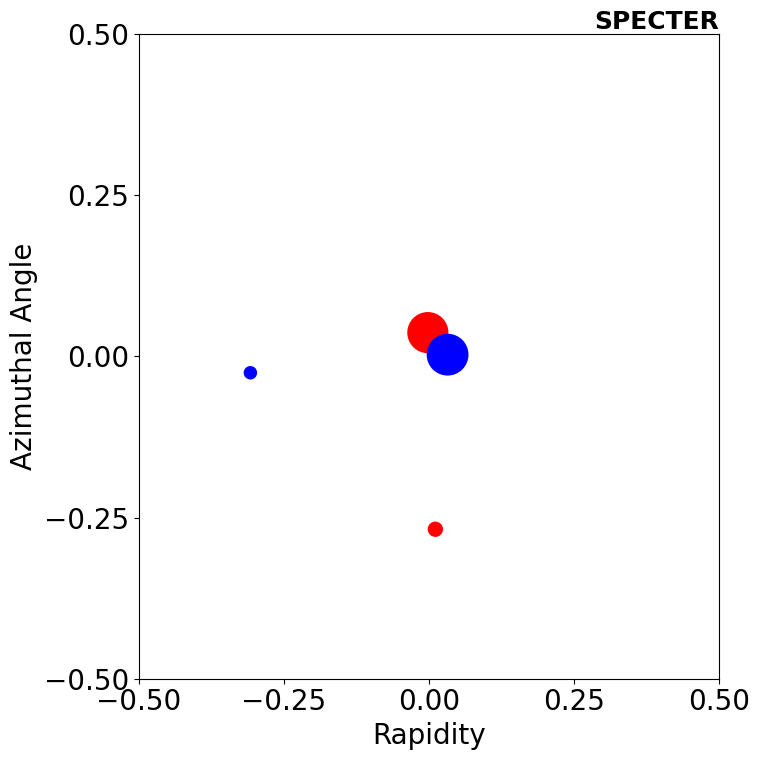

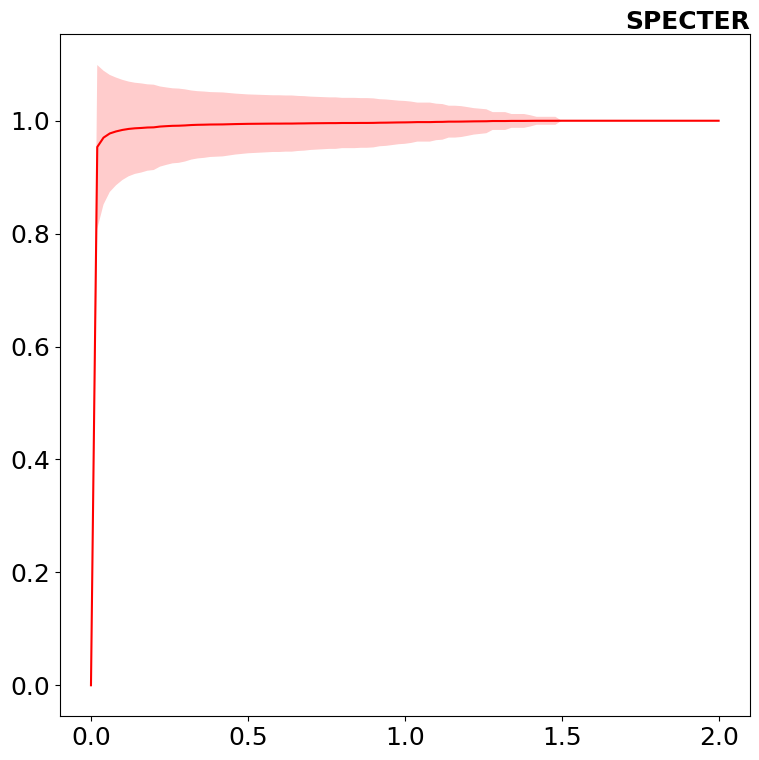

In [54]:
def lorentz_boost(events, px, py, pz):
    """
    Boost an array of events from the COM frame to a frame with momentum (px, py, pz).
    
    :param events: Array of events, shape (N_events, N_particles, 4) where each particle is described by (E, px, py, pz).
    :param px, py, pz: Components of the boost momentum.
    :return: Array of boosted events.
    """
    # Calculate the boost velocity from the given momentum
    energy = np.sqrt(px**2 + py**2 + pz**2 + np.sum(events[0, :, 0])**2)  # Assuming massless particles for the total energy calculation
    vx, vy, vz = -px / energy, -py / energy, -pz / energy

    # Lorentz boost matrix
    gamma = 1 / np.sqrt(1 - vx**2 - vy**2 - vz**2)
    L = np.array([[gamma, -gamma*vx, -gamma*vy, -gamma*vz],
                  [-gamma*vx, 1 + (gamma-1)*vx**2/(vx**2 + vy**2 + vz**2), (gamma-1)*vx*vy/(vx**2 + vy**2 + vz**2), (gamma-1)*vx*vz/(vx**2 + vy**2 + vz**2)],
                  [-gamma*vy, (gamma-1)*vy*vx/(vx**2 + vy**2 + vz**2), 1 + (gamma-1)*vy**2/(vx**2 + vy**2 + vz**2), (gamma-1)*vy*vz/(vx**2 + vy**2 + vz**2)],
                  [-gamma*vz, (gamma-1)*vz*vx/(vx**2 + vy**2 + vz**2), (gamma-1)*vz*vy/(vx**2 + vy**2 + vz**2), 1 + (gamma-1)*vz**2/(vx**2 + vy**2 + vz**2)]])

    # Apply the boost to each event
    boosted_events = np.einsum('ij,knj->kni', L, events)
    
    return boosted_events


def four_vectors_to_ptyphi(four_vectors):
    """
    Convert four-vectors to (pT, y, phi) for an event or list of events.
    
    :param four_vectors: Array of four-vectors, shape (N_events, N_particles, 4) or (N_particles, 4).
    :return: Array of (pT, y, phi) tuples.
    """
    pT = np.sqrt(four_vectors[..., 1]**2 + four_vectors[..., 2]**2)
    y = 0.5 * np.log((four_vectors[..., 0] + four_vectors[..., 3]) / (four_vectors[..., 0] - four_vectors[..., 3]))
    phi = np.arctan2(four_vectors[..., 2], four_vectors[..., 1])

    return np.stack((pT, y, phi), axis=-1)



seed = 12132
num_events = 5000
num_particles = 2
total_energy = 50
events, weights = generate_RAMBO(num_events, num_particles, total_energy, seed)

# Boost to the (500, 0, 0) frame
print(events.shape)
print(np.sum(events, axis=1))
boosted_events = lorentz_boost(events, 500, 0, 0)
print(np.sum(boosted_events, axis=1))


boosted_events = four_vectors_to_ptyphi(boosted_events)

fig, ax = newplot()
plot_event(ax, boosted_events[0], R = .5, color='red')
plot_event(ax, boosted_events[1], R = .5, color = 'blue')

# Function to compute fraction of particles within a cone of radius R for each event in pt-y-phi
def fraction_in_cone(events, R):

    # Calculate the distance between each particle and the beam axis
    d = np.sqrt(events[..., 1]**2 + events[..., 2]**2)

    # Calculate the angle between each particle and the beam axis
    theta = np.arctan2(d, events[..., 0])

    # Calculate the fraction of particles within the cone
    print(events.shape)
    fraction = np.sum(theta[None,:,:] < R[:,None,None], axis=-1) / events.shape[1]

    return fraction

# plot of the fraction in cone as a function of R
newplot()
R = np.linspace(0, 2, 101)
fraction = fraction_in_cone(boosted_events, R)
means, stds = np.mean(fraction, axis=1), np.std(fraction, axis=1)
plt.plot(R, np.mean(fraction, axis=1))
plt.fill_between(R, means - stds, means + stds, alpha=0.2)


In [55]:
# Normalized pT's
pT = boosted_events[..., 0]
pT_norm = pT / np.sum(pT, axis=-1)[:, None]
boosted_events[..., 0] = pT_norm

# Split dataset into 2 halves
dataset1 = boosted_events[:num_events//2]
dataset2 = boosted_events[num_events//2:]
weights1 = weights[:num_events//2]
weights2 = weights[num_events//2:]

print(events.shape)

(5000, 2, 4)


In [68]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)
R = 0.5

start = time.time()
specter_emds = specter.spectralEMD(dataset1, dataset2)
end = time.time()
print("SPECTER took {} seconds".format(end - start))

# Set up and compile SHAPER
shaper = Shaper({}, device)
shaper.to(device)

start = time.time()
shaper_emds = shaper.pairwise_emds_isometry(dataset1, dataset2, R = R, beta = 2, lr = 0.01, epsilon = 0.01, scaling = 0.90)
shaper_emds_no_isometry = shaper.pairwise_emds2(dataset1, dataset2, R = R, beta = 2, epsilon = 0.01)
end = time.time()
print("SHAPER took {} seconds".format(end - start))

Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  1.4727256298065186  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  25.54994010925293  seconds.
Compilation complete! Time taken:  25.5499529838562  seconds.
SPECTER took 0.4194037914276123 seconds
Epoch 0 Mean Loss = 0.015479456550812756 Elapsed time = 0.036s Percentage done = 0.000 
Epoch 1 Mean Loss = 0.01587135497224517 Elapsed time = 0.072s Percentage done = 0.000 
Epoch 2 Mean Loss = 0.015696017245249824 Elapsed time = 0.153s Percentage done = 0.000 
Epoch 3 Mean Loss = 0.015672394889954012 Elapsed time = 0.204s Percentage done = 0.000 
Epoch 4 Mean Loss = 0.015698221572558395 Elapsed time = 0.253s Percentage done = 0.000 
Epoch 5 Mean Loss = 0.01563173876753426 Elapsed time = 0.280s Percentage done = 0.000 
Epoch 6 Mean Loss = 0.015557497347275785 Elapsed time = 0.310s Percentage done = 0.000 
Epoch 7 Mean Loss

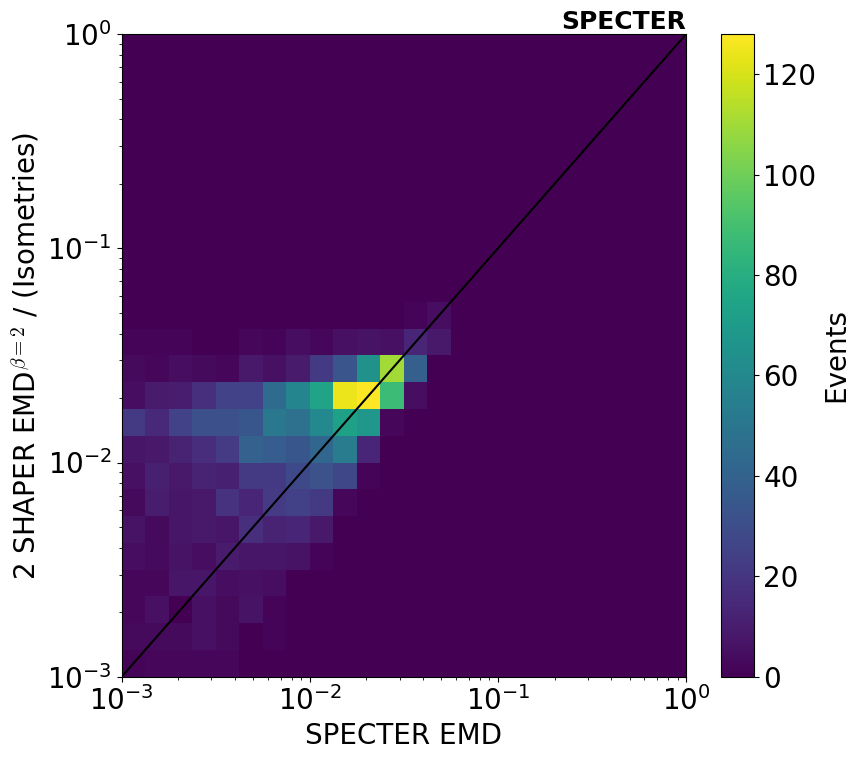

In [69]:
import matplotlib

# plt.scatter(specter_emds, shaper_emds)
# plt.scatter(specter_emds, shaper_emds_no_isometry)

# log 2d histogram
newplot(width=9)

log = False
xbins = np.logspace(-3, 0, 25)
ybins = np.logspace(-3, 0, 25)
if log:
    plt.hist2d(specter_emds, shaper_emds, norm = matplotlib.colors.LogNorm(), bins = [xbins, ybins], density=False)
else:
    plt.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], density=False)
# diagonal line
x = np.linspace(0, 1, 1000)
plt.plot(x, x, color = "black")

plt.xlabel("SPECTER EMD")
plt.ylabel(r"2 SHAPER EMD$^{\beta = 2}$ / (Isometries)")
plt.xscale("log")
plt.yscale("log")
cbabr = plt.colorbar()
cbabr.set_label("Events")

